In [1]:
# made 3/20 after make_stations confusion over which are the right time points or not

In [1]:
import numpy as np
import nibabel
import nilearn
from nilearn.image import resample_to_img
import matplotlib.pyplot as plt
from nilearn import plotting
from nilearn.plotting import show
from nilearn.plotting import plot_roi
from nilearn import image
from nilearn.masking import apply_mask
# get_ipython().magic('matplotlib inline')
import scipy
import matplotlib
import matplotlib.pyplot as plt
from nilearn import image
from nilearn.input_data import NiftiMasker
#from nilearn import plotting
import nibabel
from nilearn.masking import apply_mask
from nilearn.image import load_img
from nilearn.image import new_img_like
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets, svm, metrics
from sklearn.linear_model import Ridge
from sklearn.svm import SVC, LinearSVC
from sklearn.cross_validation import KFold
from sklearn.cross_validation import LeaveOneLabelOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.feature_selection import SelectFwe
from scipy import signal
from scipy.fftpack import fft, fftshift
from scipy import interp

params = {'legend.fontsize': 'large',
          'figure.figsize': (5, 3),
          'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}
font = {'weight': 'bold',
        'size': 22}
plt.rc('font', **font)
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectPercentile, f_classif, GenericUnivariateSelect, SelectKBest, chi2
from sklearn.feature_selection import RFE
import os
import seaborn as sns
import pandas as pd
import csv
from scipy import stats
import brainiak
import brainiak.funcalign.srm
import glob

/jukebox/pkgs/PYGER/beta/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/jukebox/pkgs/PYGER/beta/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
projectDir='/jukebox/norman/amennen/prettymouth_fmriprep2/'
DMNmask='/jukebox/norman/amennen/MNI_things/Yeo_JNeurophysiol11_MNI152/Yeo_Network7mask_reoriented_resampledBOLD.nii.gz'
fmriprep_dir=projectDir + '/derivatives/fmriprep'

# load subject numbers
subInd = 0
nsub=38
allnames = []
allgroups = []
groupInfo={}
# skip subjects 039 and 116
with open(projectDir + 'participants.tsv') as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    for row in csvReader:
        if 'sub' in row[0]:
            # now skip the subjects we don't want to analyze
            allInfo = row[0].split('\t')
            subjName=allInfo[0]
            if subjName != 'sub-039' and subjName != 'sub-116':
                if allInfo[3] == 'paranoia':
                    group = 0
                elif allInfo[3] == 'affair':
                    group = 1
                allnames.append(subjName)
                allgroups.append(group)
                subInd+=1

paranoidSubj = allnames[0:19]
cheatingSubj = allnames[19:]
paranoidLabel = allgroups[0:19]
cheatingLabel = allgroups[19:]
nfolds=19
print(allnames)
segment_score_vector = np.load('segment_score_vector.npy')
beliefs_vector = np.load('beliefs_vector.npy')
emotions_vector = np.load('emotions_vector.npy')
intentions_vector = np.load('intentions_vector.npy')

['sub-088', 'sub-089', 'sub-090', 'sub-091', 'sub-092', 'sub-093', 'sub-094', 'sub-095', 'sub-096', 'sub-097', 'sub-098', 'sub-099', 'sub-100', 'sub-101', 'sub-102', 'sub-103', 'sub-104', 'sub-105', 'sub-106', 'sub-107', 'sub-108', 'sub-109', 'sub-110', 'sub-111', 'sub-068', 'sub-081', 'sub-112', 'sub-053', 'sub-113', 'sub-031', 'sub-114', 'sub-115', 'sub-117', 'sub-118', 'sub-119', 'sub-120', 'sub-121', 'sub-122']


In [3]:
# load the winning classifier combination
# load the specified winning combination
classifierType = 1
ROI = 1
removeAvg = 1
filterType = 1
k1 = 0
k2 = 25
boostrapped = 1 # whether or not to randomly sample training data w/ replacement
lowhigh = 0

if not boostrapped:
    filename_data = glob.glob('new_bothphases/ARRAYDATA' + '_ROI_' + str(ROI) + '_AVGREMOVE_' + str(removeAvg) +  '_classifierType_' + str(classifierType) + '_filter_' + str(filterType) + '_lowhigh_' + str(lowhigh) + '_k1_' + str(k1) + '_k2_' + str(k2) + '_perm_*.npy')
else:
    filename_data = glob.glob('new_bothphases/ARRAYDATA_BS_' + '_ROI_' + str(ROI) + '_AVGREMOVE_' + str(removeAvg) +  '_classifierType_' + str(classifierType) + '_filter_' + str(filterType) + '_lowhigh_' + str(lowhigh) + '_k1_' + str(k1) + '_k2_' + str(k2) + '_perm_*.npy')
#print(filename_data)
accuracy = np.load(filename_data[0]).T # this is 450 TRs x 1000 examples
nTR = np.shape(accuracy)[1]
np.mean(accuracy)

0.5330888888888888

(447,)
(1000, 447)


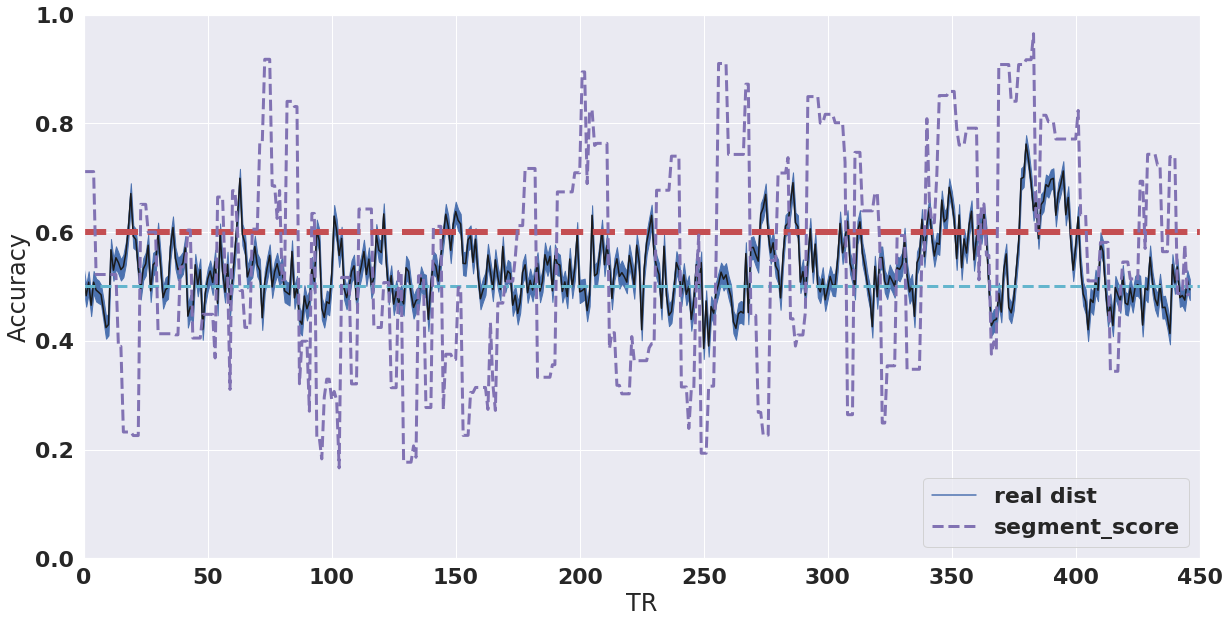

REAL correlation is 0.1687
REAL p value is 0.0003


Text(0,0.5,'Zscored segment difference')

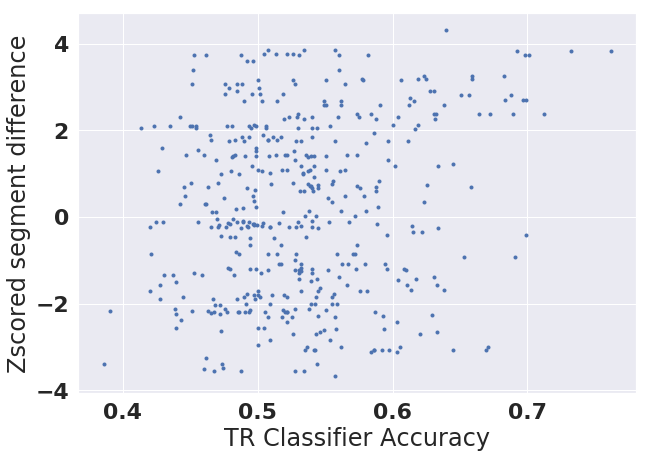

In [4]:
x = np.arange(nTR-3)
y = accuracy[:,3:]
mean_acc = np.mean(y,axis=0)

print(np.shape(x))
print(np.shape(y))
# make into dataframe: TR, accuracy
n_iter=1000
TR_vec = np.tile(x,n_iter)
data = y.flatten()

iter_number = np.repeat(np.arange(n_iter),nTR-3)
matrix = np.concatenate((TR_vec[:,np.newaxis],data[:,np.newaxis],iter_number[:,np.newaxis]),axis=1)
df = pd.DataFrame(data=matrix, columns = ['TR', 'accuracy','iter'])

sns.set(style="white")
sns.set(font_scale=2)
err_band = {}
err_band['alpha'] = 1

plt.figure(figsize=(20,10))
sns.lineplot(x="TR",y="accuracy",color='b',data=df,ci=95,err_kws=err_band,label='real dist')

plt.plot(x,np.mean(y,axis=0), color='k')
#plt.plot(x,np.mean(y,axis=0), color='k', label='accuracy')
plt.plot([0 ,500], [.6, .6], 'r--', lw=6)
plt.plot([0 ,500], [.5, .5], 'c--', lw=3)
plt.ylim([0,1])
plt.xlim([0,nTR])

plt.plot(segment_score_vector[0:-3]/10 + np.mean(y), '--', color='m', label='segment_score',linewidth=3)
plt.plot()
plt.legend(loc=4)
plt.ylabel('Accuracy')
plt.show()
[corr,p] = scipy.stats.pearsonr(mean_acc,segment_score_vector[0:-3])
print('REAL correlation is %4.4f' % corr)
print('REAL p value is %4.4f' % p)

plt.figure(figsize=(10,7))
plt.plot(mean_acc,segment_score_vector[0:-3], '.')
plt.xlabel('TR Classifier Accuracy')
plt.ylabel('Zscored segment difference')

[ 64  65 147 148 149 150 151 152 153 154 155 211 212 280 281 285 286 287
 295 296 308 309 310 315 316 317 341 342 343 344 345 346 347 348 349 350
 351 352 353 354 355 356 358 359 360 361 365 366 367 380 381 382 383 384
 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 403
 404 413 414]
[ 14  16  20  21  22  23  24  29  33  38  39  40  44  58  64  65  66  67
  68  72  78  87  97  98 104 105 106 107 116 118 121 122 123 124 147 148
 149 150 151 152 153 154 155 158 159 161 166 172 189 191 193 199 202 208
 211 212 214 218 223 226 230 231 232 233 237 270 272 273 274 276 277 278
 279 280 281 285 286 287 288 289 290 291 295 296 298 308 309 310 311 315
 316 317 324 325 334 340 341 342 343 344 345 346 347 348 349 350 351 352
 353 354 355 356 358 359 360 361 363 364 365 366 367 375 380 381 382 383
 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401
 403 404 413 414 433]


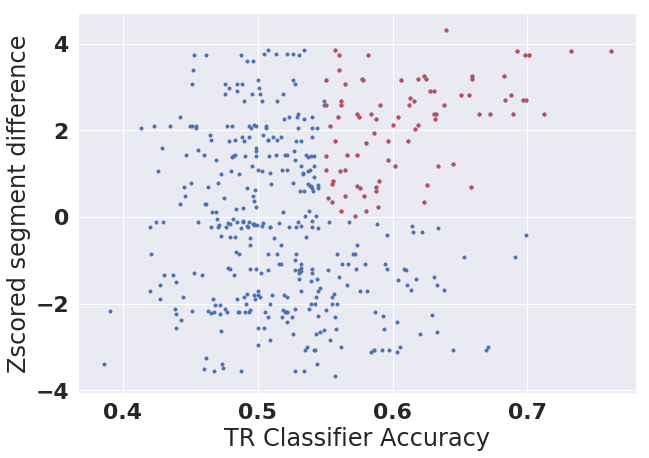

In [5]:
seg_shifted = segment_score_vector[0:-3]
TR_vector = np.arange(len(seg_shifted))
large_diff = seg_shifted > 0
large_acc = mean_acc > 0.55
upper_right = np.intersect1d(TR_vector[large_diff],TR_vector[large_acc])

plt.figure(figsize=(10,7))
plt.plot(mean_acc,segment_score_vector[0:-3], '.')
plt.plot(mean_acc[upper_right],seg_shifted[upper_right], 'r.')
plt.xlabel('TR Classifier Accuracy')
plt.ylabel('Zscored segment difference')

#print(upper_right)
# adding a couple points with high accuracy
points_to_add = np.arange(144,153)
#print(points_to_add)
new_upper_right = np.sort(np.concatenate((upper_right,points_to_add),axis=0))
differences = np.diff(new_upper_right)
good_diff = np.argwhere(differences==1)
good_time_points = []
for i in np.arange(len(good_diff)):
    this_diff = good_diff[i][0]
    good_time_points.append(new_upper_right[this_diff])
    good_time_points.append(new_upper_right[this_diff+1])
final_good = np.unique(good_time_points)

#print(final_good)
print(final_good+3)
shifted_back = final_good+3

print(TR_vector[large_acc]+3)

In [8]:
# going to buid dictionary--adding a couple more where it makes sense adn the score diff was higher right before and will retest again

station_dict = {}
station_dict[0] = [64,65]
station_dict[1] = [147, 148, 149, 150, 151, 152, 153, 154 ,155]
station_dict[2] = [211, 212]
station_dict[3] = [280, 281]
station_dict[4] = [285, 286, 287]
station_dict[5] = [295, 296]
station_dict[6] = [308 ,309, 310]
station_dict[7] = [315, 316, 317]
station_dict[8] = [341, 342, 343, 344, 345, 346 ,347 ,348 ,349 ,350, 351, 352, 353, 354, 355 ,356]
station_dict[9] = [358, 359 ,360, 361]
station_dict[10] = [365, 366, 367]
station_dict[11] = [380, 381, 382, 383, 384, 385 ,386 ,387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401]
station_dict[12] = [ 403, 404]
station_dict[13] = [413,414]
station_dict[14] = [433, 434] # added to see if this is okay


In [9]:
np.save('stations_upper_right.npy', station_dict)